In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import torch
import torch.nn as nn
import seaborn as sns
sns.set()
from model import MultiModalTransformer, MultiModalConv
from main import test_epoch
from data import dataloaders

device = torch.device('cuda:1')
exp_src = Path('./runs')
task = 'inhospital_mortality'

In [38]:
def eval_fn(model_name, ts, modalities, data_root='./data'):
    exp_path = exp_src / task / f'{model_name}_{"_".join(modalities)}' / ts
    with_text = 'text' in modalities
    with_diagnoses = 'diagnoses' in modalities
    modalities = [m for m in modalities if m not in ['text', 'diagnoses']]
    _model_name = {
        # 'swin': 'microsoft/swin-base-patch4-window7-224-in22k',
        'swin': 'microsoft/swin-large-patch4-window12-384-in22k',
        'vit': 'google/vit-base-patch16-224',
        'conv': 'google/vit-base-patch16-224' # only for the preprocessor
    }[model_name]
    model_class = MultiModalTransformer if model_name != 'conv' else MultiModalConv
    model = model_class(
        img_model_name=_model_name,
        img_modalities=modalities,
        with_text=with_text,
        task=task
    )#.to(device)
    model = nn.DataParallel(model)
    ckpt = torch.load(exp_path / 'checkpoint.pt')#, map_location=device)
    model.load_state_dict(ckpt)
    model = model.module.to(device)
    _,_,testloader = dataloaders(
        img_model_name=_model_name, 
        modalities=modalities, 
        with_diagnoses=with_diagnoses,
        root=data_root,
        image_size=384,
        task=task
    )
    pos_weight = torch.tensor(4168 / 717).to(device) # n_neg / n_pos
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    y_true, y_prob = test_epoch(model, criterion, testloader, modalities, device)
    return y_true, y_prob

In [39]:
ys_true, ys_prob = {}, {}

In [40]:
experiments = [
    ['swin', ['lab','text']],
    ['swin', ['med', 'text']],
    ['swin', ['cxr', 'text']],
    ['swin', ['ecg', 'text']],
    ['swin', ['lab', 'cxr', 'text']],
    ['swin', ['lab','med','cxr','ecg','text','diagnoses']]
]

In [41]:
for model_name, modalities in experiments:
    exp_name = f'{model_name}_{"_".join(modalities)}'
    ys_true[exp_name] = []
    ys_prob[exp_name] = []
    timestamps = [x.name for x in (exp_src /task / exp_name).iterdir()]
    for i, ts in enumerate(timestamps):
        y_true, y_prob = eval_fn(
            model_name=model_name, 
            ts=ts, 
            modalities=modalities,
            data_root='/mnt/hdd/data/MMMedViT_data/data'
        )
        ys_true[exp_name].append(y_true)
        ys_prob[exp_name].append(y_prob)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [30]:
import pandas as pd
ys_prob_mean = {k: torch.stack(v).mean(0) for k, v in ys_prob.items()}
ys_prob_std = {k: torch.stack(v).std(0) for k, v in ys_prob.items()}

dfs = []
for model_name, modalities in experiments:
    exp_name = f'{model_name}_{"_".join(modalities)}'
    modalities = [m for m in modalities if m not in ['text','diagnoses']]
    _,_,testloader = dataloaders(
        img_model_name='google/vit-base-patch16-224', 
        modalities=modalities,
        root='/mnt/hdd/data/MMMedViT_data/data',
        task=task
    )
    stay_ids = testloader.dataset.data.stay_id.tolist()
    y_true = testloader.dataset.data.y_true.tolist()
    
    i = 0
    ys_prob_i = ys_prob[exp_name][i].flatten()
    dfi = pd.DataFrame.from_dict({'stay_id': stay_ids, 'y_true': y_true, exp_name: ys_prob_i})
    dfs.append(dfi)

In [36]:
y_true = dfs[0].set_index('stay_id').y_true
df = pd.DataFrame([df.set_index('stay_id')[df.columns[-1]] for df in dfs]).T
df['y_true'] = y_true
df.to_csv(f'results_ViTiMM_{task}.csv')
df

,swin_lab_text,swin_med_text,swin_cxr_text,swin_ecg_text,swin_lab_cxr_text,swin_lab_med_cxr_ecg_text_diagnoses,y_true
stay_id,,,,,,,
30008792,0.193546,0.475056,0.822056,0.476070,0.614302,0.305298,1
30009123,0.015755,0.291267,0.103424,0.140598,0.049464,0.013982,0
30009597,0.742484,0.500244,0.746755,0.615504,0.620785,0.944517,1
30009753,0.747420,0.468689,0.913119,0.607680,0.417776,0.886910,0
30022756,0.127118,0.411215,0.176093,0.466201,0.050603,0.149327,0
...,...,...,...,...,...,...,...
39970416,0.071834,0.700435,0.371966,0.578458,0.070380,0.042467,0
39972274,0.072215,0.231143,0.675282,NaN,0.160729,0.135811,0
39972327,0.170641,0.159267,0.105504,0.266358,0.048591,0.011602,0


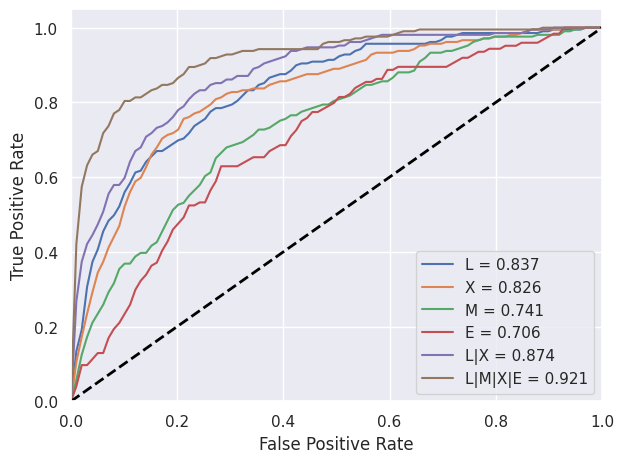

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import roc_auc_score, roc_curve, auc

exps = [
    ['swin_lab_text', 'L'],
    ['swin_cxr_text', 'X'],
    ['swin_med_text', 'M'],
    ['swin_ecg_text', 'E'],
    ['swin_lab_cxr_text', 'L|X'],
    ['swin_lab_med_cxr_ecg_text_diagnoses', 'L|M|X|E']
]

mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
cp = sns.color_palette()
for j, (exp_name, label) in enumerate(exps):
    tprs, aucs = [],[]
    # for i in range(1,4):
    y_prob = df.dropna(subset=[exp_name])[exp_name]
    y_true = df.dropna(subset=[exp_name]).y_true
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    # tprs.append(interp_tpr)
    # aucs.append(auc(fpr, tpr))
    # mean_tpr = np.mean(tprs, axis=0)
    # std_tpr = np.std(tprs, axis=0)
    # mean_tpr[-1] = 1.0

    mean_auc = auc(mean_fpr, interp_tpr)
    std_auc = np.std(aucs)
    l = f'{label} = {mean_auc:.3f}' # ± {std_auc:.3f})'
    ax.plot(mean_fpr, interp_tpr, label=l, color=cp[j])
    # ax.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2, color=cp[j])
ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig(f'images/roc_auc_ours_{task}.png', bbox_inches='tight')

In [34]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

data = []
for exp_name, mods_string in exps:
    for exp_ts_path in (exp_src / task / exp_name).iterdir():
        ea = EventAccumulator(str(exp_ts_path))
        ea.Reload()
        rocauc = ea.Scalars('test/rocauc')[-1].value
        auprc = ea.Scalars('test/auprc')[-1].value
        balanced_acc = ea.Scalars('test/balanced_accuracy')[-1].value
        # mods_string = '|'.join([mods_short[m] for m in modalities])
        data.append({
            # 'model': model_name, 
            'modalities': mods_string, 
            'ROCAUC': rocauc,
            'AUPRC': auprc,
            'Bal.Acc.': balanced_acc
        })

In [35]:
pd.DataFrame(data).round(3)#.to_latex()

,modalities,ROCAUC,AUPRC,Bal.Acc.
0,L,0.837,0.512,0.743
1,X,0.826,0.494,0.758
2,M,0.741,0.346,0.680
3,E,0.704,0.297,0.636
4,L|X,0.875,0.615,0.776
5,L|M|X|E,0.922,0.764,0.847
